In [1]:
from __future__ import print_function, division
from builtins import range, input

import os,sys
from keras.models import Model
from keras.layers import Input, LSTM,GRU,Dense,Embedding, Bidirectional, RepeatVector,Concatenate,Activation,Dot,Lambda
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import keras.backend as K

import numpy as np
import matplotlib.pyplot as plt



Using TensorFlow backend.


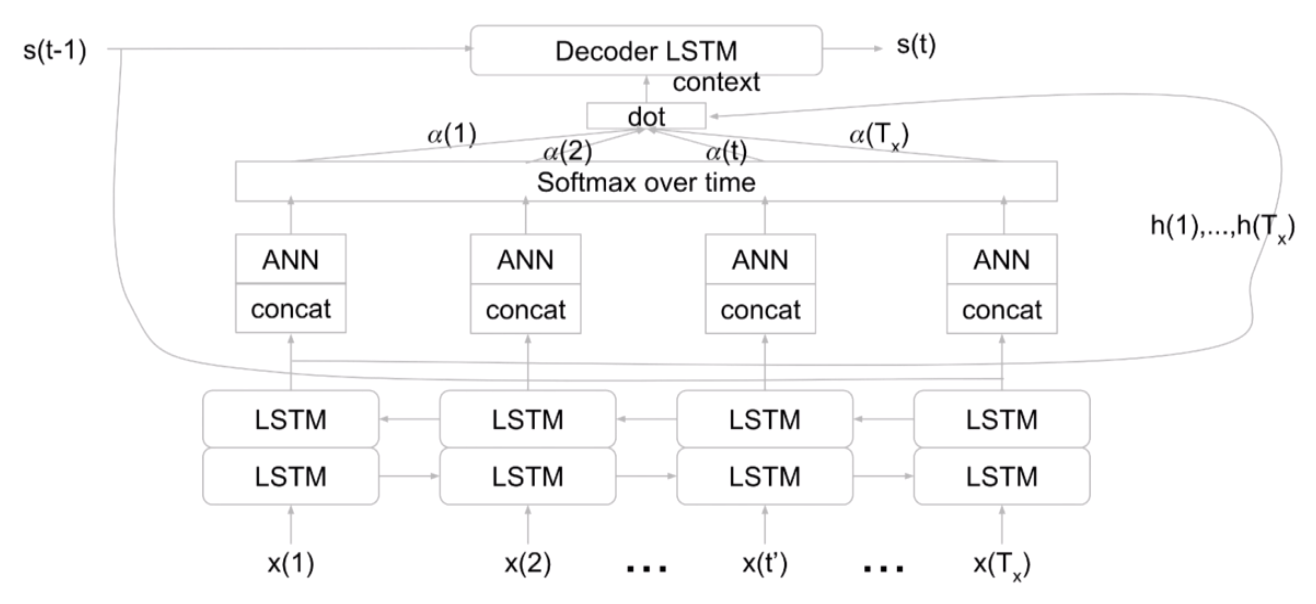

#### Softmax over time

- make sure we do softmax over the time axis
- expected shape is N x T x D
- note: the latest version of Keras allows you to pass in axis arg

In [3]:
def softmax_over_time(x):
    assert(K.ndim(x) > 2)
    e = K.exp(x - K.max(x,axis = 1,keepdims = True))
    s = K.sum(e,axis = 1,keepdims = True)
    
    return e/s

#### config

In [5]:
BATCH_SIZE = 64
EPOCHS = 100
LATENT_DIM = 256
LATENT_DIM_DECODER = 256 # idea: make it different to ensure things all fit together properly!
NUM_SAMPLES = 10000
MAX_SEQUENCE_LENGTH = 100
MAX_NUM_WORDS = 20000
EMBEDDING_DIM = 100

input_texts = []
target_texts = []
target_texts_inputs = []



#### load in data

In [6]:
t = 0
for line in open('data/translation/spa.txt',encoding = 'utf8'):
    # only keep a limited number of samples
    t = t+1
    if t > NUM_SAMPLES:
        break
        
    # input and target are separated by tab    
    if '\t' not in line:
        continue
        
    # input and target are separated by tab    
    input_text, translation = line.rstrip().split('\t')
    
    
  # make the target input and output
  # recall we'll be using teacher forcing
    
    target_text = translation + ' <eos>'
    target_text_input = '<sos> ' +translation
    
    input_texts.append(input_text)
    target_texts.append(target_text)
    target_texts_inputs.append(target_text_input)
    
print("num samples:",len(input_texts))


    


num samples: 10000


#### Data Preprcoessing

In [10]:
tokenizer_inputs = Tokenizer(num_words = MAX_NUM_WORDS)
tokenizer_inputs.fit_on_texts(input_texts)
input_sequences = tokenizer_inputs.texts_to_sequences(input_texts)

# get the word to index mapping for input language

word2idx_inputs = tokenizer_inputs.word_index
print('Found %s unique input tokens.'%len(word2idx_inputs))

#determine maximum length input sequence

max_len_input = max(len(s) for s in input_sequences)

# tokenize the outputs
# don't filter out special characters
# otherwise <sos> and <eos> won't appear

tokenizer_outputs = Tokenizer(num_words = MAX_NUM_WORDS, filters = '')
tokenizer_outputs.fit_on_texts(target_texts + target_texts_inputs)
target_sequences = tokenizer_outputs.texts_to_sequences(target_texts)
target_sequences_inputs = tokenizer_outputs.texts_to_sequences(target_texts_inputs)

# get the word to index mapping for output language
word2idx_outputs = tokenizer_outputs.word_index
print('Found %s unique output tokens.' % len(word2idx_outputs))

# store number of output words for later
# remember to add 1 since indexing starts at 1

num_words_output = len(word2idx_outputs) +1


# determine maximum length output sequence

max_len_target = max(len(s) for s in target_sequences)

# pad the sequences

encoder_inputs = pad_sequences(input_sequences,maxlen = max_len_input)
print('encoder_data.shape:', encoder_inputs.shape)
print("encoder_data[0]:", encoder_inputs[0])

decoder_inputs = pad_sequences(target_sequences_inputs, maxlen = max_len_target,padding = 'post')
print('decoder_data[0]:', decoder_inputs[0])
print('decoder_data.shape:', decoder_inputs.shape)

decoder_targets = pad_sequences(target_sequences, maxlen = max_len_target,padding = 'post')

Found 2367 unique input tokens.
Found 6325 unique output tokens.
encoder_data.shape: (10000, 5)
encoder_data[0]: [ 0  0  0  0 15]
decoder_data[0]: [   2 1491    0    0    0    0    0    0    0]
decoder_data.shape: (10000, 9)


#### Word Embedding Preprcoessing

In [15]:
# store all the pre-trained word vectors

word2vec = {}
with open(os.path.join('large_files/glove.6B/glove.6B.%sd.txt' % EMBEDDING_DIM),encoding = 'utf8') as f:
   # is just a space-separated text file in the format:
  # word vec[0] vec[1] vec[2] ...
    
    for line in f:
        values = line.split()
        word = values[0]
        vec = np.asarray(values[1:],dtype = 'float32')
        word2vec[word] = vec
        
print('Found %s word vectors.' % len(word2vec))


# prepare embedding matrix


num_words = min(MAX_NUM_WORDS,len(word2idx_inputs)+1)
embedding_matrix = np.zeros((num_words,EMBEDDING_DIM))
for word, i in word2idx_inputs.items():
    if i < MAX_NUM_WORDS:
        embedding_vector = word2vec.get(word)
        
        if embedding_vector is not None:
            # words not found in embedding index will be all zeros.
            embedding_matrix[i] = embedding_vector
            

# create embedding layer

embedding_layer = Embedding(num_words, EMBEDDING_DIM,
                           weights = [embedding_matrix],
                           input_length = max_len_input,
                           )

# create targets, since we cannot use sparse categorical cross entropy when we have sequences

decoder_targets_one_hot = np.zeros((len(input_texts),
                                 max_len_target,
                                 num_words_output), dtype=  'float32')


# assign the values

for i, d in enumerate(decoder_targets):
    for t, word in enumerate(d):
        decoder_targets_one_hot[i,t,word] = 1


Found 400000 word vectors.


#### build the model 


In [16]:
# Set up the encoder - simple!

encoder_inputs_placeholder = Input(shape = (max_len_input,))
x = embedding_layer(encoder_inputs_placeholder)
encoder = Bidirectional(LSTM(LATENT_DIM,
                       return_sequences = True,))

encoder_outputs = encoder(x)

# Set up the decoder - not so simple

decoder_inputs_placeholder = Input(shape = (max_len_target,))

# this word embedding will not use pre-trained vectors
# although you could

decoder_embedding = Embedding(num_words_output,EMBEDDING_DIM)
decoder_inputs_x = decoder_embedding(decoder_inputs_placeholder)


Instructions for updating:
keep_dims is deprecated, use keepdims instead


#### Attention layer

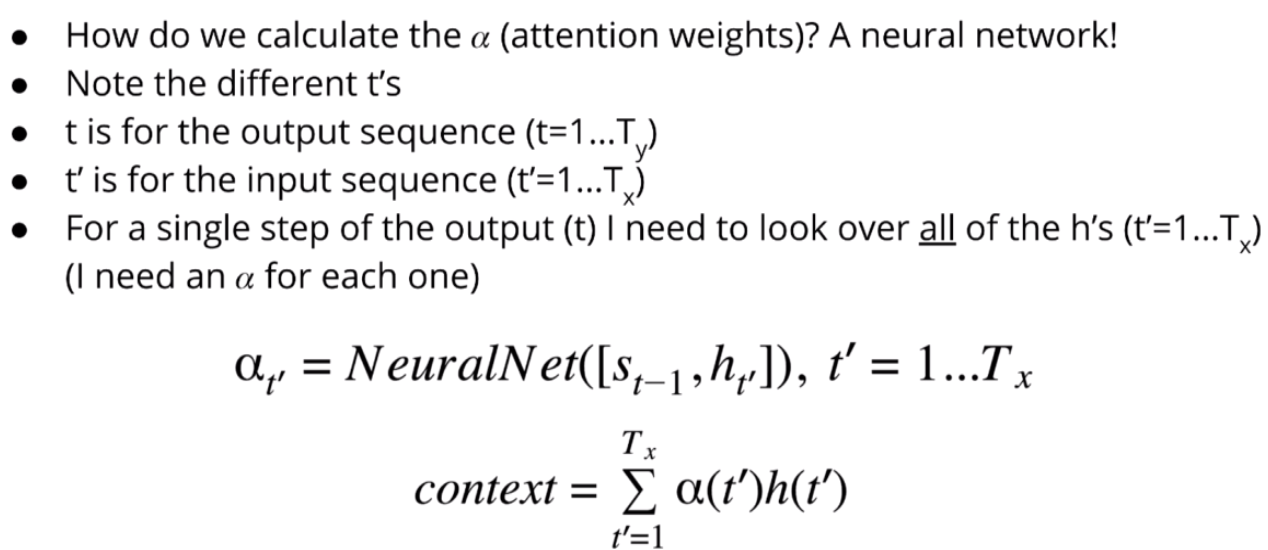



In [17]:
# Attention layers need to be global because they will be repeated Ty times at the decoder

attn_repeat_layer = RepeatVector(max_len_input)
attn_concat_layer = Concatenate(axis = -1)
attn_dense1 = Dense(10,activation = 'tanh')
attn_dense2 = Dense(1,activation = softmax_over_time)
attn_dot = Dot(axes = 1) # to perform the weighted sum of alpha[t] * h[t]

def one_step_attention(h,st_1):
    
  # h = h(1), ..., h(Tx), shape = (Tx, LATENT_DIM * 2)
  # st_1 = s(t-1), shape = (LATENT_DIM_DECODER,)
 
  # copy s(t-1) Tx times
  # now shape = (Tx, LATENT_DIM_DECODER)

    st_1 = attn_repeat_layer(st_1)
    
  # Concatenate all h(t)'s with s(t-1)
  # Now of shape (Tx, LATENT_DIM_DECODER + LATENT_DIM * 2)
    
    x = attn_concat_layer([h,st_1])

  # Neural net first layer
    x = attn_dense1(x)
    
  # Neural net second layer with special softmax over time

    alphas = attn_dense2(x)
    
  # "Dot" the alphas and the h's
  # Remember a.dot(b) = sum over a[t] * b[t]
    
    context = attn_dot([alphas,h])
    
    return context
    
    
    
    
 


#### Decoder

In [24]:
decoder_lstm = LSTM(LATENT_DIM_DECODER,return_state = True)
decoder_dense = Dense(num_words_output,activation = 'softmax')

initial_s = Input(shape = (LATENT_DIM_DECODER,),name = 's0')
initial_c = Input(shape = (LATENT_DIM_DECODER,),name = 'c0')
context_last_word_concat_layer = Concatenate(axis = 2)

# Unlike previous seq2seq, we cannot get the output all in one step
# Instead we need to do Ty steps And in each of those steps, we need to consider all Tx h's

# s, c will be re-assigned in each iteration of the loop

s = initial_s
c = initial_c
outputs = []

for t in range(max_len_target):   # Ty times
  # get the context using attentio

    context = one_step_attention(encoder_outputs,s)
    
    # we need a different layer for each time step

    selector = Lambda(lambda x:x[:,t:t+1])
    xt = selector(decoder_inputs_x)
    
    # combine 
    decoder_lstm_input = context_last_word_concat_layer([context,xt])
    
    # pass the combined [context, last word] into the LSTM
    # along with [s, c]
    # get the new [s, c] and output
    o,s,c = decoder_lstm(decoder_lstm_input,initial_state = [s,c])
    # final dense layer to get next word prediction
    decoder_outputs = decoder_dense(o)
    outputs.append(decoder_outputs)
    
    
# 'outputs' is now a list of length Ty
# each element is of shape (batch size, output vocab size)
# therefore if we simply stack all the outputs into 1 tensor
# it would be of shape T x N x D
# we would like it to be of shape N x T x D    

def stack_and_transpose(x):
    # x is a list of length T, each element is a batch_size x output_vocab_size tensor
    
    x = K.stack(x)
    x = K.permute_dimensions(x,pattern = (1,0,2)) # is now batch_size x T x output_vocab_size
    
    return x

# make it a layer

stacker = Lambda(stack_and_transpose)
outputs = stacker(outputs)

###  create the model

model = Model(inputs = [encoder_inputs_placeholder,
                        decoder_inputs_placeholder,
                        initial_s, initial_c],
             outputs = outputs)


    
model.summary()   
    


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 5)            0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 5, 100)       236800      input_1[0][0]                    
__________________________________________________________________________________________________
s0 (InputLayer)                 (None, 256)          0                                            
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 5, 512)       731136      embedding_2[0][0]                
__________________________________________________________________________________________________
repeat_vec

#### Train the model

In [27]:
model.compile(optimizer = 'rmsprop',loss = 'categorical_crossentropy',metrics = ['accuracy'])

z = np.zeros((NUM_SAMPLES,LATENT_DIM_DECODER)) ##  initial [s, c]
r = model.fit([encoder_inputs, decoder_inputs,z,z],decoder_targets_one_hot,
             batch_size = BATCH_SIZE,
             epochs = EPOCHS,
             validation_split = 0.2,
             verbose = 1)


Instructions for updating:
keep_dims is deprecated, use keepdims instead
Train on 8000 samples, validate on 2000 samples
Epoch 1/100
8000/8000 [==============================] - 27s 3ms/step - loss: 2.7354 - acc: 0.6328 - val_loss: 2.6839 - val_acc: 0.6564
Epoch 2/100
8000/8000 [==============================] - 15s 2ms/step - loss: 2.0757 - acc: 0.7085 - val_loss: 2.4960 - val_acc: 0.6708
Epoch 3/100
8000/8000 [==============================] - 15s 2ms/step - loss: 1.8475 - acc: 0.7276 - val_loss: 2.3303 - val_acc: 0.6854
Epoch 4/100
8000/8000 [==============================] - 15s 2ms/step - loss: 1.6770 - acc: 0.7472 - val_loss: 2.2005 - val_acc: 0.7036
Epoch 5/100
8000/8000 [==============================] - 15s 2ms/step - loss: 1.5414 - acc: 0.7642 - val_loss: 2.1281 - val_acc: 0.7143
Epoch 6/100
8000/8000 [==============================] - 15s 2ms/step - loss: 1.4230 - acc: 0.7780 - val_loss: 2.0626 - val_acc: 0.7231
Epoch 7/100
8000/8000 [==============================] - 15s 2m

8000/8000 [==============================] - 17s 2ms/step - loss: 0.1823 - acc: 0.9545 - val_loss: 2.4299 - val_acc: 0.7228
Epoch 59/100
8000/8000 [==============================] - 17s 2ms/step - loss: 0.1795 - acc: 0.9541 - val_loss: 2.4527 - val_acc: 0.7208
Epoch 60/100
8000/8000 [==============================] - 17s 2ms/step - loss: 0.1771 - acc: 0.9543 - val_loss: 2.4471 - val_acc: 0.7217
Epoch 61/100
8000/8000 [==============================] - 17s 2ms/step - loss: 0.1736 - acc: 0.9550 - val_loss: 2.4807 - val_acc: 0.7221
Epoch 62/100
8000/8000 [==============================] - 17s 2ms/step - loss: 0.1707 - acc: 0.9548 - val_loss: 2.4781 - val_acc: 0.7228
Epoch 63/100
8000/8000 [==============================] - 17s 2ms/step - loss: 0.1678 - acc: 0.9555 - val_loss: 2.4796 - val_acc: 0.7214
Epoch 64/100
8000/8000 [==============================] - 17s 2ms/step - loss: 0.1643 - acc: 0.9551 - val_loss: 2.4890 - val_acc: 0.7207
Epoch 65/100
8000/8000 [==============================

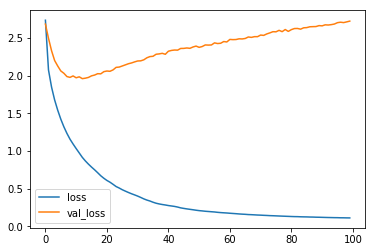

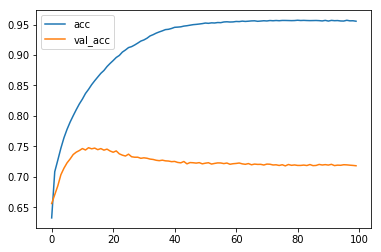

In [28]:
# plot some data
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

# accuracies
plt.plot(r.history['acc'], label='acc')
plt.plot(r.history['val_acc'], label='val_acc')
plt.legend()
plt.show()

#### Prediction Model

In [39]:

# As with the poetry example, we need to create another model
# that can take in the RNN state and previous word as input
# and accept a T=1 sequence.

# The encoder will be stand-alone
# From this we will get our initial decoder hidden state
# i.e. h(1), ..., h(Tx)
encoder_model = Model(encoder_inputs_placeholder, encoder_outputs)

# next we define a T=1 decoder model
encoder_outputs_as_input = Input(shape=(max_len_input, LATENT_DIM * 2,))
decoder_inputs_single = Input(shape=(1,))
decoder_inputs_single_x = decoder_embedding(decoder_inputs_single)

# no need to loop over attention steps this time because there is only one step
context = one_step_attention(encoder_outputs_as_input, initial_s)

# combine context with last word
decoder_lstm_input = context_last_word_concat_layer([context, decoder_inputs_single_x])

# lstm and final dense
o, s, c = decoder_lstm(decoder_lstm_input, initial_state=[initial_s, initial_c])
decoder_outputs = decoder_dense(o)


# note: we don't really need the final stack and tranpose
# because there's only 1 output
# it is already of size N x D
# no need to make it 1 x N x D --> N x 1 x D



# create the model object
decoder_model = Model(
  inputs=[
    decoder_inputs_single,
    encoder_outputs_as_input,
    initial_s, 
    initial_c
  ],
  outputs=[decoder_outputs, s, c]
)



# map indexes back into real words
# so we can view the results
idx2word_eng = {v:k for k, v in word2idx_inputs.items()}
idx2word_trans = {v:k for k, v in word2idx_outputs.items()}


def decode_sequence(input_seq):
  # Encode the input as state vectors.
    enc_out = encoder_model.predict(input_seq)

  # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1))
  
  # Populate the first character of target sequence with the start character.
  # NOTE: tokenizer lower-cases all words
    target_seq[0, 0] = word2idx_outputs['<sos>']

  # if we get this we break
    eos = word2idx_outputs['<eos>']


  # [s, c] will be updated in each loop iteration
    s = np.zeros((1, LATENT_DIM_DECODER))
    c = np.zeros((1, LATENT_DIM_DECODER))


  # Create the translation
    output_sentence = []
    for _ in range(max_len_target):
        o, s, c = decoder_model.predict([target_seq, enc_out, s, c])
        

    # Get next word
        idx = np.argmax(o.flatten())

    # End sentence of EOS
        if eos == idx:
            break

      
        word = ''
        if idx > 0:
            word = idx2word_trans[idx]
            output_sentence.append(word)

    # Update the decoder input
    # which is just the word just generated
        target_seq[0, 0] = idx

    return ' '.join(output_sentence)
    


#### Translate sentence

In [49]:
i = np.random.choice(len(input_texts))
input_seq = encoder_inputs[i:i+1]
translation = decode_sequence(input_seq)

print('Input sentence:', input_texts[i])
print('Predicted translation:', translation)
print('Actual translation:', target_texts[i])

Input sentence: Tom likes me.
Predicted translation: le gusto a tom.
Actual translation: Le gusto a Tom. <eos>
